In [ ]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.vector_ar.vecm import coint_johansen
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.tsatools import lagmat
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.ar_model import ar_select_order
from scipy.stats import chi2
from statsmodels.graphics.gofplots import qqplot

In [ ]:
wti = pd.read_csv('/content/Cushing_OK_WTI_Spot_Price_FOB.csv',
                  skiprows=4)
wti = wti.rename(columns={'Cushing OK WTI Spot Price FOB Dollars per Barrel': 'WTI'})
wti['Month'] = pd.to_datetime(wti['Month'])
wti = wti[wti['Month'].dt.year >= 1990]
wti = wti.sort_values(by='Month', ascending=True)
wti

<ipython-input-2-3754e0c8a7de>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  wti['Month'] = pd.to_datetime(wti['Month'])


,Month,WTI
424,1990-01-01,22.86
423,1990-02-01,22.11
422,1990-03-01,20.39
421,1990-04-01,18.43
420,1990-05-01,18.20
...,...,...
4,2025-01-01,75.74
3,2025-02-01,71.53
2,2025-03-01,68.24
1,2025-04-01,63.54


In [ ]:
gasoline = pd.read_excel('/content/PET_PRI_GND_A_EPM0_PTE_DPGAL_M.xls', skiprows=2)
gasoline = gasoline.rename(columns={'U.S. All Grades All Formulations Retail Gasoline Prices (Dollars per Gallon)': 'Gasoline'})
gasoline['Date'] = pd.to_datetime(gasoline['Date'])
gasoline = gasoline[gasoline['Date'].dt.year >= 1990]
# gasoline = gasoline.sort_values(by='Date', ascending=False)
gasoline

,Date,Gasoline
0,1993-04-15,1.078
1,1993-05-15,1.100
2,1993-06-15,1.097
3,1993-07-15,1.078
4,1993-08-15,1.062
...,...,...
381,2025-01-15,3.196
382,2025-02-15,3.247
383,2025-03-15,3.223
384,2025-04-15,3.299


In [ ]:
diesel = pd.read_csv('/content/U.S._No_2_Diesel_Retail_Prices.csv', skiprows=4)
diesel = diesel.rename(columns={'U.S. No 2 Diesel Retail Prices Dollars per Gallon': 'Diesel'})
diesel['Month'] = pd.to_datetime(diesel['Month'])
diesel = diesel[diesel['Month'].dt.year >= 1990]
diesel = diesel.sort_values(by='Month', ascending=True)
diesel

<ipython-input-4-515643ac9e3e>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  diesel['Month'] = pd.to_datetime(diesel['Month'])


,Month,Diesel
373,1994-04-01,1.107
372,1994-05-01,1.100
371,1994-06-01,1.103
370,1994-07-01,1.110
369,1994-08-01,1.123
...,...,...
4,2025-01-01,3.634
3,2025-02-01,3.675
2,2025-03-01,3.585
1,2025-04-01,3.567


In [ ]:
start = datetime.datetime(1990, 1, 1)
end = datetime.datetime.now()

dollar = web.DataReader("DTWEXBGS", 'fred', start, end)
dollar = dollar.resample('ME').mean()
dollar = dollar[dollar.index >= start]
dollar.reset_index(inplace=True)
dollar = dollar.rename(columns={'DTWEXBGS': 'Dollar'})
dollar

,DATE,Dollar
0,2006-01-31,100.000005
1,2006-02-28,100.211170
2,2006-03-31,100.428087
3,2006-04-30,99.743480
4,2006-05-31,97.511774
...,...,...
228,2025-01-31,129.041257
229,2025-02-28,128.066505
230,2025-03-31,126.486433
231,2025-04-30,124.455677


In [ ]:
df = pd.concat([wti, gasoline['Gasoline']], axis=1)
df = df.dropna()
df = pd.concat([df, diesel['Diesel']], axis=1)
df = df.dropna()
df = pd.concat([df, dollar['Dollar']], axis=1)
df = df.dropna()
df = df.sort_values(by='Month', ascending=False)
df

,Month,WTI,Gasoline,Diesel,Dollar
0,2025-05-01,62.17,1.078,3.499,100.000005
1,2025-04-01,63.54,1.100,3.567,100.211170
2,2025-03-01,68.24,1.097,3.585,100.428087
3,2025-02-01,71.53,1.078,3.675,99.743480
4,2025-01-01,75.74,1.062,3.634,97.511774
...,...,...,...,...,...
228,2006-05-01,70.84,3.958,2.897,129.041257
229,2006-04-01,69.44,3.791,2.728,128.066505
230,2006-03-01,62.69,3.596,2.559,126.486433
231,2006-02-01,61.63,3.498,2.475,124.455677


In [ ]:
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
df.sort_index(inplace=True)
df

,WTI,Gasoline,Diesel,Dollar
Month,,,,
2006-01-01,65.49,3.780,2.467,122.686910
2006-02-01,61.63,3.498,2.475,124.455677
2006-03-01,62.69,3.596,2.559,126.486433
2006-04-01,69.44,3.791,2.728,128.066505
2006-05-01,70.84,3.958,2.897,129.041257
...,...,...,...,...
2025-01-01,75.74,1.062,3.634,97.511774
2025-02-01,71.53,1.078,3.675,99.743480
2025-03-01,68.24,1.097,3.585,100.428087


In [ ]:
df_log = np.log(df[['WTI', 'Gasoline', 'Diesel', 'Dollar']])
df_log.head()

,WTI,Gasoline,Diesel,Dollar
Month,,,,
2006-01-01,4.181897,1.329724,0.903003,4.809636
2006-02-01,4.121149,1.252191,0.906240,4.823950
2006-03-01,4.138202,1.279822,0.939617,4.840135
2006-04-01,4.240463,1.332630,1.003569,4.852550
2006-05-01,4.260424,1.375739,1.063676,4.860132


## **ADF test**

In [ ]:
def adf_test(series, title=''):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Test for {title}')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('-'*30)

for col in df_log.columns:
    adf_test(df_log[col], title=col)

ADF Test for WTI
ADF Statistic: -3.5703
p-value: 0.0064
------------------------------
ADF Test for Gasoline
ADF Statistic: -1.4412
p-value: 0.5624
------------------------------
ADF Test for Diesel
ADF Statistic: -3.0023
p-value: 0.0347
------------------------------
ADF Test for Dollar
ADF Statistic: -1.7294
p-value: 0.4160
------------------------------


## **KPSS test**

In [ ]:
def kpss_test(series, title=''):
    result = kpss(series)
    print(f'KPSS Test for {title}')
    print(f'KPSS Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    print('-'*30)

for col in df_log.columns:
    kpss_test(df_log[col])

KPSS Test for 
KPSS Statistic: 0.3215
p-value: 0.1000
------------------------------
KPSS Test for 
KPSS Statistic: 2.2484
p-value: 0.0100
------------------------------
KPSS Test for 
KPSS Statistic: 0.2939
p-value: 0.1000
------------------------------
KPSS Test for 
KPSS Statistic: 1.8830
p-value: 0.0100
------------------------------


<ipython-input-10-b48de0006232>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)
<ipython-input-10-b48de0006232>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series)
<ipython-input-10-b48de0006232>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series)
<ipython-input-10-b48de0006232>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series)


## **differencing non stationary dataset**

In [ ]:
df_diff = df_log[['Gasoline', 'Dollar']].diff().dropna()

def run_diff_stationarity_tests(series, name):
    adf_result = adfuller(series, autolag='AIC')  # ADF tests H0: unit root (I(1))
    # The kpss function returns (statistic, p-value, critical values, trend)
    kpss_result = kpss(series, regression='c', nlags='auto')
    kpss_statistic = kpss_result[0]
    kpss_p_value = kpss_result[1] # Extract the p-value

    return {
        'Series': name,
        'ADF Statistic': round(adf_result[0], 4),
        'ADF p-value': round(adf_result[1], 4),
        'KPSS Statistic': round(kpss_statistic, 4),
        'KPSS p-value': round(kpss_p_value, 4)}

columns_to_test_diff = ['Gasoline', 'Dollar']
results_diff = [run_diff_stationarity_tests(df_diff[col], col) for col in columns_to_test_diff]
results_diff_df = pd.DataFrame(results_diff)

results_diff_df

<ipython-input-11-5ee946119634>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')
<ipython-input-11-5ee946119634>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_result = kpss(series, regression='c', nlags='auto')


,Series,ADF Statistic,ADF p-value,KPSS Statistic,KPSS p-value
0,Gasoline,-5.2710,0.0,0.0536,0.1
1,Dollar,-9.4397,0.0,0.1125,0.1


## **Johansen test**

In [ ]:
df_coint = df_log[['Gasoline', 'Dollar']].dropna()

johansen_test = coint_johansen(df_coint, det_order=0, k_ar_diff=1)

johansen_results = {
    "Eigenvalues": johansen_test.eig,
    "Trace Statistic": johansen_test.lr1,
    "Trace 90% Crit Value": johansen_test.cvt[:, 0],
    "Trace 95% Crit Value": johansen_test.cvt[:, 1],
    "Trace 99% Crit Value": johansen_test.cvt[:, 2]}

# Engle-Granger (residual-based) test for WTI (I(0)) and Gasoline (I(1))
coint_stat, coint_pval, _ = coint(df_log['Gasoline'], df_log['WTI'])
johansen_results, (coint_stat, coint_pval)

({'Eigenvalues': array([0.06898772, 0.01025508]),
  'Trace Statistic': array([18.89368195,  2.38115362]),
  'Trace 90% Crit Value': array([13.4294,  2.7055]),
  'Trace 95% Crit Value': array([15.4943,  3.8415]),
  'Trace 99% Crit Value': array([19.9349,  6.6349])},
 (np.float64(-1.7585145115064857), np.float64(0.6496454021891674)))

In [ ]:
coint_result = coint(df_log['Gasoline'], df_log['WTI'])
print(f"Statistic: {coint_result[0]}, p-value: {coint_result[1]}")

Statistic: -1.7585145115064857, p-value: 0.6496454021891674


## **TECM Gasoline model**

In [ ]:
y = df_log['Gasoline']
X = sm.add_constant(df_log['Dollar'])
cointegration_model = OLS(y, X).fit()
residuals = cointegration_model.resid
resid_lag = residuals.shift(1)

tecm = df_log.copy().dropna()
tecm['ECT'] = resid_lag[tecm.index]

vars_to_lag = tecm[['Gasoline', 'WTI', 'Dollar']]
lagged_vars = lagmat(vars_to_lag, maxlag=1, trim='both')
lagged_df = pd.DataFrame(
    lagged_vars,
    columns=[f'{col}_lag1' for col in vars_to_lag.columns],
    index=tecm.index[1:])

aligned_df = tecm.iloc[1:].copy()
aligned_df = pd.concat([aligned_df, lagged_df], axis=1)

threshold_grid = np.percentile(aligned_df['ECT'].dropna(), np.arange(15, 90, 5))
min_ssr = np.inf
best_tau = None

for tau in threshold_grid:
    aligned_df['Regime'] = np.where(aligned_df['ECT'] <= tau, 'low', 'high')
    df_low = aligned_df[aligned_df['Regime'] == 'low']
    df_high = aligned_df[aligned_df['Regime'] == 'high']

    if len(df_low) < 30 or len(df_high) < 30:
        continue

    model_low = OLS(df_low['Gasoline'], sm.add_constant(df_low[['ECT', 'WTI_lag1', 'Dollar_lag1']])).fit(cov_type='HC3')
    model_high = OLS(df_high['Gasoline'], sm.add_constant(df_high[['ECT', 'WTI_lag1', 'Dollar_lag1']])).fit(cov_type='HC3')

    total_ssr = sum(model_low.resid ** 2) + sum(model_high.resid ** 2)

    if total_ssr < min_ssr:
        min_ssr = total_ssr
        best_tau = tau
        best_low_model = model_low
        best_high_model = model_high

(best_tau, best_low_model.summary(), best_high_model.summary())

(np.float64(0.15941171701127116),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:               Gasoline   R-squared:                       0.979
 Model:                            OLS   Adj. R-squared:                  0.979
 Method:                 Least Squares   F-statistic:                     3845.
 Date:                Sun, 08 Jun 2025   Prob (F-statistic):          6.18e-156
 Time:                        07:59:26   Log-Likelihood:                 252.17
 No. Observations:                 174   AIC:                            -496.3
 Df Residuals:                     170   BIC:                            -483.7
 Df Model:                           3                                         
 Covariance Type:                  HC3                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
 ----------------------------------

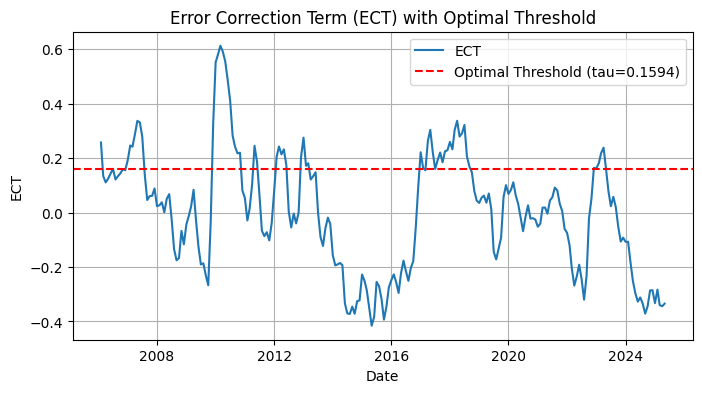

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot(aligned_df.index, aligned_df['ECT'], label='ECT')
plt.axhline(y=best_tau, color='r', linestyle='--', label=f'Optimal Threshold (tau={best_tau:.4f})')
plt.title('Error Correction Term (ECT) with Optimal Threshold')
plt.xlabel('Date')
plt.ylabel('ECT')
plt.legend()
plt.grid(True)
plt.show()

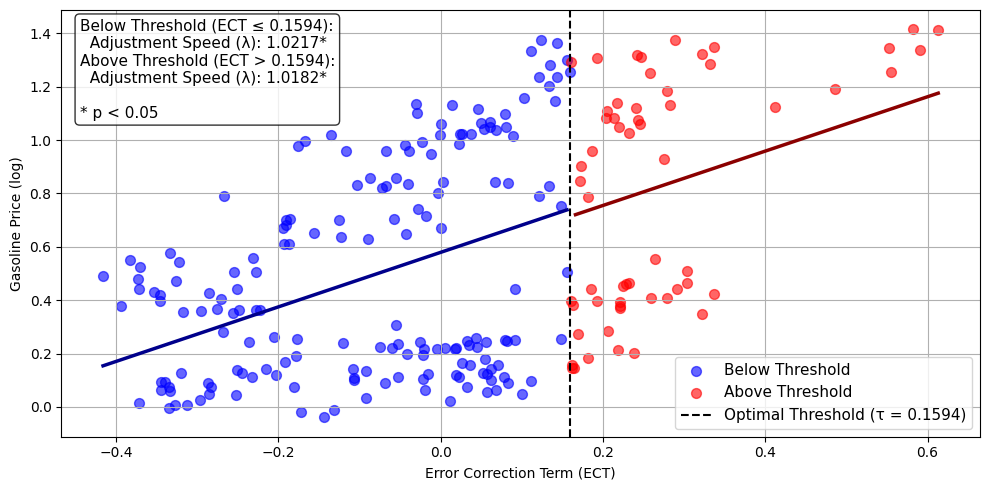

In [ ]:
plot_df = aligned_df.copy()
plot_df['Regime'] = np.where(plot_df['ECT'] <= best_tau, 'Below Threshold', 'Above Threshold')

plt.figure(figsize=(10, 5))

colors = {'Below Threshold': 'blue', 'Above Threshold': 'red'}
for regime, color in colors.items():
    subset = plot_df[plot_df['Regime'] == regime]
    plt.scatter(subset['ECT'], subset['Gasoline'],
               alpha=0.6, color=color, label=regime, s=50)

plt.axvline(x=best_tau, color='black', linestyle='--',
            label=f'Optimal Threshold (τ = {best_tau:.4f})')
x_vals = np.linspace(plot_df['ECT'].min(), plot_df['ECT'].max(), 100)

mean_wti_lag1 = plot_df['WTI_lag1'].mean()
mean_dollar_lag1 = plot_df['Dollar_lag1'].mean()

# Below threshold regression line data
X_below_plot_df = pd.DataFrame({
    'ECT': x_vals[x_vals <= best_tau],
    'WTI_lag1': mean_wti_lag1,
    'Dollar_lag1': mean_dollar_lag1})

X_below_plot = sm.add_constant(X_below_plot_df, has_constant='add')

# Above threshold regression line data
X_above_plot_df = pd.DataFrame({
    'ECT': x_vals[x_vals > best_tau],
    'WTI_lag1': mean_wti_lag1,
    'Dollar_lag1': mean_dollar_lag1})
X_above_plot = sm.add_constant(X_above_plot_df, has_constant='add')

plt.plot(x_vals[x_vals <= best_tau], best_low_model.predict(X_below_plot),
         color='darkblue', linewidth=2.5, linestyle='-')

plt.plot(x_vals[x_vals > best_tau], best_high_model.predict(X_above_plot),
         color='darkred', linewidth=2.5, linestyle='-')

plt.xlabel('Error Correction Term (ECT)')
plt.ylabel('Gasoline Price (log)')
# plt.title('Threshold Error Correction Model: Gasoline Price Adjustment', fontsize=14)
plt.legend(fontsize=11)
plt.grid()

annotation_text = (
    f"Below Threshold (ECT ≤ {best_tau:.4f}):\n"
    f"  Adjustment Speed (λ): {best_low_model.params['ECT']:.4f}{'*' if best_low_model.pvalues['ECT'] < 0.05 else ''}\n"
    f"Above Threshold (ECT > {best_tau:.4f}):\n"
    f"  Adjustment Speed (λ): {best_high_model.params['ECT']:.4f}{'*' if best_high_model.pvalues['ECT'] < 0.05 else ''}\n"
    f"\n* p < 0.05")
plt.annotate(annotation_text, xy=(0.02, 0.98), xycoords='axes fraction',
             ha='left', va='top', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/graphics/gofplots.py:1041: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


TypeError: cannot concatenate object of type '<class 'pandas.core.indexes.datetimes.DatetimeIndex'>'; only Series and DataFrame objs are valid

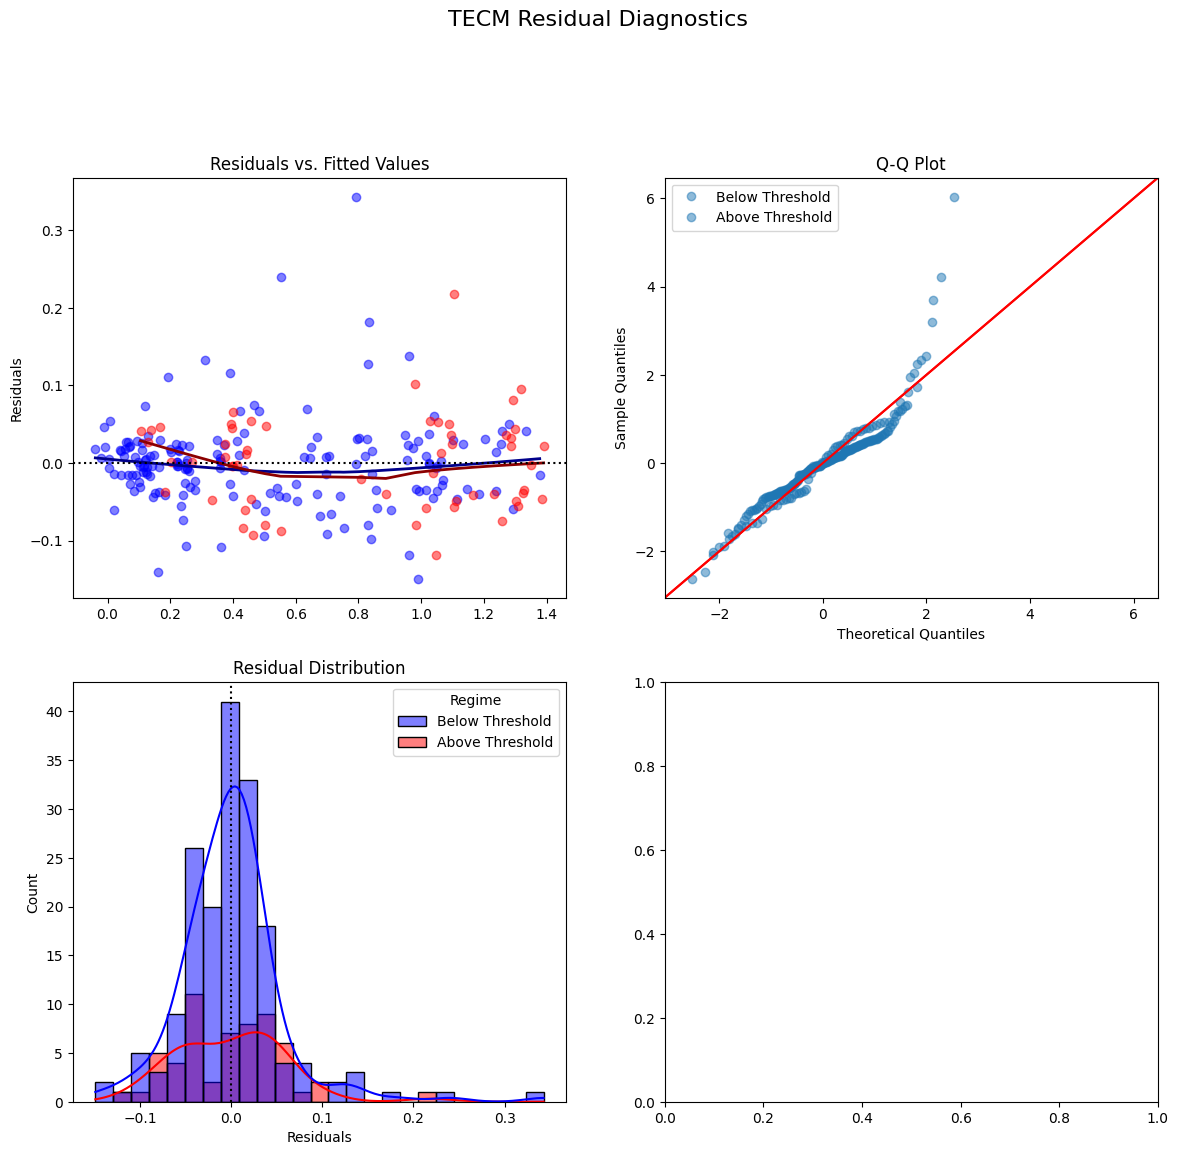

In [ ]:
residuals = pd.concat([
    pd.Series(best_low_model.resid, name='Residuals').to_frame().assign(Regime='Below Threshold'),
    pd.Series(best_high_model.resid, name='Residuals').to_frame().assign(Regime='Above Threshold')])

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
plt.suptitle('TECM Residual Diagnostics', y=1.02, fontsize=16)

# Residuals vs. Fitted Values
for regime, color in [('Below Threshold', 'blue'), ('Above Threshold', 'red')]:
    regime_resid = residuals[residuals['Regime'] == regime]
    sns.regplot(
        x=best_low_model.fittedvalues if regime == 'Below Threshold' else best_high_model.fittedvalues,
        y=regime_resid['Residuals'],
        lowess=True,
        scatter_kws={'alpha': 0.5, 'color': color},
        line_kws={'color': 'dark'+color, 'lw': 2},
        ax=axes[0,0])
axes[0,0].axhline(0, color='black', linestyle=':')
axes[0,0].set_title('Residuals vs. Fitted Values')
axes[0,0].set_ylabel('Residuals')

# Q-Q Plot
qqplot(best_low_model.resid, line='45', fit=True, ax=axes[0,1], color='blue', alpha=0.5, label='Below Threshold')
qqplot(best_high_model.resid, line='45', fit=True, ax=axes[0,1], color='red', alpha=0.5, label='Above Threshold')
axes[0,1].set_title('Q-Q Plot')
axes[0,1].legend()

# Residual Distribution
sns.histplot(residuals, x='Residuals', hue='Regime', kde=True,
             palette=['blue', 'red'], ax=axes[1,0])
axes[1,0].set_title('Residual Distribution')
axes[1,0].axvline(0, color='black', linestyle=':')

# Residuals over Time
residuals['Time'] = pd.concat([best_low_model.model.data.row_labels,
                              best_high_model.model.data.row_labels])
sns.lineplot(data=residuals, x='Time', y='Residuals', hue='Regime',
             palette=['blue', 'red'], ax=axes[1,1])
axes[1,1].axhline(0, color='black', linestyle=':')
axes[1,1].set_title('Residuals over Time')

plt.tight_layout()
plt.show()

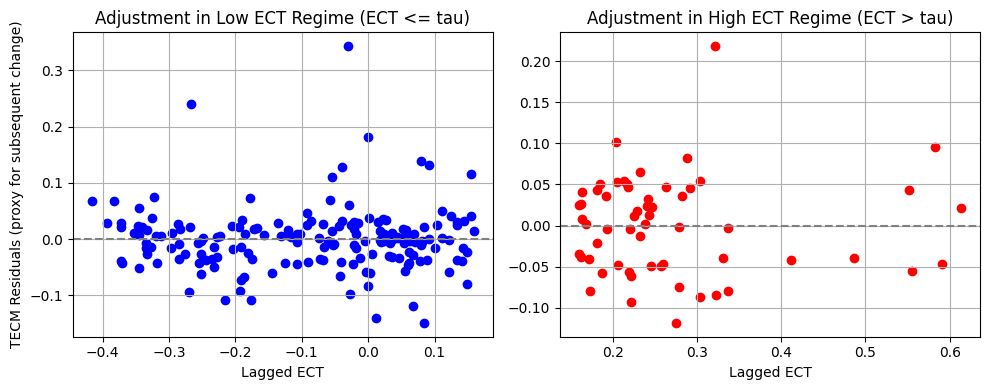

In [ ]:
residuals_low_regime = best_low_model.resid
residuals_high_regime = best_high_model.resid

ect_low_regime = aligned_df.loc[residuals_low_regime.index, 'ECT']
ect_high_regime = aligned_df.loc[residuals_high_regime.index, 'ECT']

plt.figure(figsize=(10, 4))

# Low ECT Regime
plt.subplot(1, 2, 1)
plt.scatter(ect_low_regime, residuals_low_regime, color='blue', label='Low ECT Regime')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Adjustment in Low ECT Regime (ECT <= tau)')
plt.xlabel('Lagged ECT')
plt.ylabel('TECM Residuals (proxy for subsequent change)')
plt.grid(True)

# High ECT Regime
plt.subplot(1, 2, 2)
plt.scatter(ect_high_regime, residuals_high_regime, color='red', label='High ECT Regime')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Adjustment in High ECT Regime (ECT > tau)')
plt.xlabel('Lagged ECT')
# plt.ylabel('TECM Residuals (proxy for subsequent change)')
plt.grid(True)

plt.tight_layout()
plt.show()


## **Wald Test**

In [ ]:
lambda_low = best_low_model.params['ECT']
lambda_high = best_high_model.params['ECT']

var_lambda_low = best_low_model.cov_params().loc['ECT', 'ECT']
var_lambda_high = best_high_model.cov_params().loc['ECT', 'ECT']

diff = lambda_low - lambda_high
var_diff = var_lambda_low + var_lambda_high
wald_stat = (diff)**2 / var_diff

p_value = 1 - chi2.cdf(wald_stat, df=1)

print(f"Wald Test for Asymmetric Adjustment:")
print(f"λ (Below Threshold): {lambda_low:.4f} (SE: {np.sqrt(var_lambda_low):.4f})")
print(f"λ (Above Threshold): {lambda_high:.4f} (SE: {np.sqrt(var_lambda_high):.4f})")
print(f"Difference: {diff:.4f}")
print(f"Wald Statistic: {wald_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("\nConclusion: Reject null hypothesis - Significant asymmetry in adjustment speeds (λ₁ ≠ λ₂)")
else:
    print("\nConclusion: Cannot reject null hypothesis - No evidence of asymmetric adjustment")

Wald Test for Asymmetric Adjustment:
λ (Below Threshold): 1.0217 (SE: 0.0250)
λ (Above Threshold): 1.0182 (SE: 0.0746)
Difference: 0.0035
Wald Statistic: 0.0019
p-value: 0.9649

Conclusion: Cannot reject null hypothesis - No evidence of asymmetric adjustment


## **Diesel TECM model**

In [ ]:
y = df_log['Diesel']
X = sm.add_constant(df_log['Dollar'])
cointegration_model = OLS(y, X).fit()
residuals = cointegration_model.resid
resid_lag = residuals.shift(1)

tecm = df_log.copy().dropna()
tecm['ECT'] = resid_lag[tecm.index]

vars_to_lag = tecm[['Diesel', 'WTI', 'Dollar']]
lagged_vars = lagmat(vars_to_lag, maxlag=1, trim='both')
lagged_df = pd.DataFrame(
    lagged_vars,
    columns=[f'{col}_lag1' for col in vars_to_lag.columns],
    index=tecm.index[1:])

aligned_df = tecm.iloc[1:].copy()
aligned_df = pd.concat([aligned_df, lagged_df], axis=1)

threshold_grid = np.percentile(aligned_df['ECT'].dropna(), np.arange(15, 90, 5))
min_ssr = np.inf
best_tau = None

for tau in threshold_grid:
    aligned_df['Regime'] = np.where(aligned_df['ECT'] <= tau, 'low', 'high')
    df_low = aligned_df[aligned_df['Regime'] == 'low']
    df_high = aligned_df[aligned_df['Regime'] == 'high']

    if len(df_low) < 30 or len(df_high) < 30:
        continue

    model_low = OLS(df_low['Diesel'], sm.add_constant(df_low[['ECT', 'WTI_lag1', 'Dollar_lag1']])).fit(cov_type='HAC', cov_kwds={'maxlags': 12})
    model_high = OLS(df_high['Diesel'], sm.add_constant(df_high[['ECT', 'WTI_lag1', 'Dollar_lag1']])).fit(cov_type='HAC', cov_kwds={'maxlags': 12})

    total_ssr = sum(model_low.resid ** 2) + sum(model_high.resid ** 2)

    if total_ssr < min_ssr:
        min_ssr = total_ssr
        best_tau = tau
        best_low_model = model_low
        best_high_model = model_high

(best_tau, best_low_model.summary(), best_high_model.summary())

(np.float64(0.026065287146062956),
 <class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:                 Diesel   R-squared:                       0.913
 Model:                            OLS   Adj. R-squared:                  0.911
 Method:                 Least Squares   F-statistic:                     925.3
 Date:                Sun, 08 Jun 2025   Prob (F-statistic):           1.17e-84
 Time:                        09:50:22   Log-Likelihood:                 244.66
 No. Observations:                 128   AIC:                            -481.3
 Df Residuals:                     124   BIC:                            -469.9
 Df Model:                           3                                         
 Covariance Type:                  HAC                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
 ---------------------------------

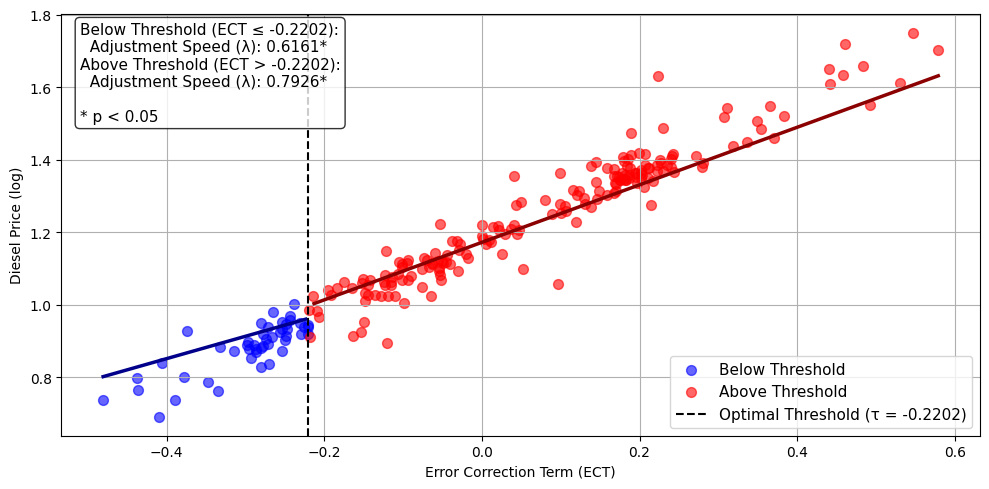

In [ ]:
plot_df = aligned_df.copy()
plot_df['Regime'] = np.where(plot_df['ECT'] <= best_tau, 'Below Threshold', 'Above Threshold')

plt.figure(figsize=(10, 5))

colors = {'Below Threshold': 'blue', 'Above Threshold': 'red'}
for regime, color in colors.items():
    subset = plot_df[plot_df['Regime'] == regime]
    plt.scatter(subset['ECT'], subset['Diesel'],
               alpha=0.6, color=color, label=regime, s=50)

plt.axvline(x=best_tau, color='black', linestyle='--',
            label=f'Optimal Threshold (τ = {best_tau:.4f})')
x_vals = np.linspace(plot_df['ECT'].min(), plot_df['ECT'].max(), 100)

mean_wti_lag1 = plot_df['WTI_lag1'].mean()
mean_dollar_lag1 = plot_df['Dollar_lag1'].mean()

# Below threshold regression line data
X_below_plot_df = pd.DataFrame({
    'ECT': x_vals[x_vals <= best_tau],
    'WTI_lag1': mean_wti_lag1,
    'Dollar_lag1': mean_dollar_lag1})

X_below_plot = sm.add_constant(X_below_plot_df, has_constant='add')

# Above threshold regression line data
X_above_plot_df = pd.DataFrame({
    'ECT': x_vals[x_vals > best_tau],
    'WTI_lag1': mean_wti_lag1,
    'Dollar_lag1': mean_dollar_lag1})
X_above_plot = sm.add_constant(X_above_plot_df, has_constant='add')

plt.plot(x_vals[x_vals <= best_tau], best_low_model.predict(X_below_plot),
         color='darkblue', linewidth=2.5, linestyle='-')

plt.plot(x_vals[x_vals > best_tau], best_high_model.predict(X_above_plot),
         color='darkred', linewidth=2.5, linestyle='-')

plt.xlabel('Error Correction Term (ECT)')
plt.ylabel('Diesel Price (log)')
# plt.title('Threshold Error Correction Model: Diesel Price Adjustment')
plt.legend(fontsize=11)
plt.grid()

annotation_text = (
    f"Below Threshold (ECT ≤ {best_tau:.4f}):\n"
    f"  Adjustment Speed (λ): {best_low_model.params['ECT']:.4f}{'*' if best_low_model.pvalues['ECT'] < 0.05 else ''}\n"
    f"Above Threshold (ECT > {best_tau:.4f}):\n"
    f"  Adjustment Speed (λ): {best_high_model.params['ECT']:.4f}{'*' if best_high_model.pvalues['ECT'] < 0.05 else ''}\n"
    f"\n* p < 0.05")
plt.annotate(annotation_text, xy=(0.02, 0.98), xycoords='axes fraction',
             ha='left', va='top', fontsize=11,
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

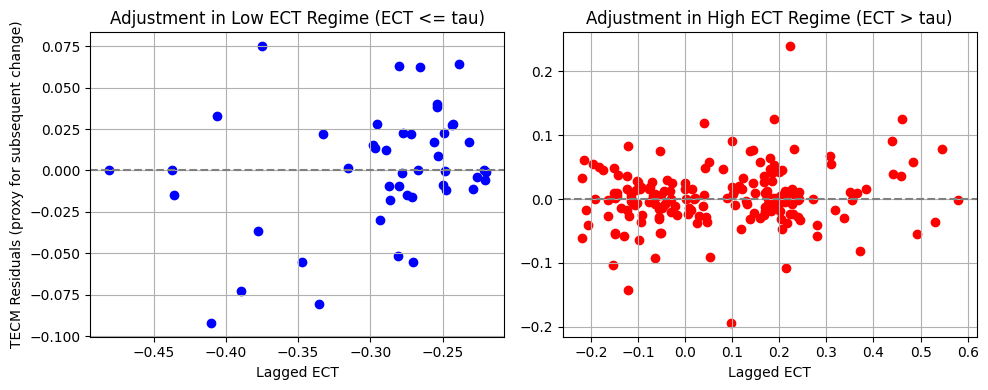

In [ ]:
residuals_low_regime = best_low_model.resid
residuals_high_regime = best_high_model.resid

ect_low_regime = aligned_df.loc[residuals_low_regime.index, 'ECT']
ect_high_regime = aligned_df.loc[residuals_high_regime.index, 'ECT']

plt.figure(figsize=(10, 4))

# Low ECT Regime
plt.subplot(1, 2, 1)
plt.scatter(ect_low_regime, residuals_low_regime, color='blue', label='Low ECT Regime')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Adjustment in Low ECT Regime (ECT <= tau)')
plt.xlabel('Lagged ECT')
plt.ylabel('TECM Residuals (proxy for subsequent change)')
plt.grid(True)

# High ECT Regime
plt.subplot(1, 2, 2)
plt.scatter(ect_high_regime, residuals_high_regime, color='red', label='High ECT Regime')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Adjustment in High ECT Regime (ECT > tau)')
plt.xlabel('Lagged ECT')
# plt.ylabel('TECM Residuals (proxy for subsequent change)')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
lambda_low = best_low_model.params['ECT']
lambda_high = best_high_model.params['ECT']

var_lambda_low = best_low_model.cov_params().loc['ECT', 'ECT']
var_lambda_high = best_high_model.cov_params().loc['ECT', 'ECT']

diff = lambda_low - lambda_high
var_diff = var_lambda_low + var_lambda_high
wald_stat = (diff)**2 / var_diff

p_value = 1 - chi2.cdf(wald_stat, df=1)

print(f"Wald Test for Asymmetric Adjustment:")
print(f"λ (Below Threshold): {lambda_low:.4f} (SE: {np.sqrt(var_lambda_low):.4f})")
print(f"λ (Above Threshold): {lambda_high:.4f} (SE: {np.sqrt(var_lambda_high):.4f})")
print(f"Difference: {diff:.4f}")
print(f"Wald Statistic: {wald_stat:.4f}")
print(f"p-value: {p_value:.4f}")

if p_value < 0.05:
    print("\nConclusion: Reject null hypothesis - Significant asymmetry in adjustment speeds (λ₁ ≠ λ₂)")
else:
    print("\nConclusion: Cannot reject null hypothesis - No evidence of asymmetric adjustment")

Wald Test for Asymmetric Adjustment:
λ (Below Threshold): 0.6161 (SE: 0.1184)
λ (Above Threshold): 0.7926 (SE: 0.0331)
Difference: -0.1765
Wald Statistic: 2.0604
p-value: 0.1512

Conclusion: Cannot reject null hypothesis - No evidence of asymmetric adjustment
